In [0]:
!pip install tweet-preprocessor
import pandas as pd
import numpy as np
import scipy as sp
import re
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from copy import deepcopy
from bs4 import BeautifulSoup
import nltk
nltk.download('stopwords')
from nltk.stem import PorterStemmer 

import preprocessor as p

  Created wheel for tweet-preprocessor: filename=tweet_preprocessor-0.5.0-cp36-none-any.whl size=7947 sha256=a1166ab5835d61c841110f04d4f6871ee4a98836a256434a65cb84c3eca90728
  Stored in directory: /root/.cache/pip/wheels/1b/27/cc/49938e98a2470802ebdefae9d2b3f524768e970c1ebbe2dc4a
Successfully built tweet-preprocessor
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
train = pd.read_csv("/content/drive/My Drive/WebProject/labeledTrainData.csv", delimiter="\t",names=["tweet", "label", "labelValue"])

In [0]:
train["label"].replace({"spam": "neutral", "normal": "neutral"}, inplace=True)

In [0]:
train.head()


,tweet,label,labelValue
0,Beats by Dr. Dre urBeats Wired In-Ear Headphon...,neutral,4
1,RT @Papapishu: Man it would fucking rule if we...,abusive,4
2,It is time to draw close to Him &#128591;&#127...,neutral,4
3,if you notice me start to act different or dis...,neutral,5
4,"Forget unfollowers, I believe in growing. 7 ne...",neutral,3


In [0]:
def expand_hashtags(tweet):
    ws.load()
    new_tweet = "" # output    
    tokens = tweet.split(' ')    
    for t in tokens:
        if t[0] == '#': # this is a hashtag, parse it
            hashtags_tokens = ws.segment(t)
            exp = " ".join(hashtags_tokens)
            new_tweet += exp
        else: # Just append the word
            new_tweet += t
        new_tweet += " "

    return new_tweet 


In [0]:
####Preprocessing for K_Means

def preprocess_tweet_KMeans(tweet):

    # 1. Remove URLs, emojis, mentions, smileys using tweet-preprocessor library
    # should not remove hashtags as hashtags contains important tweet content.
    
    #p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.MENTION,p.OPT.RESERVED,	p.OPT.SMILEY,p.OPT.NUMBER)
    clean = p.clean(tweet)
    # 2. Remove HTML tags using Beautiful soup library
    no_tag = BeautifulSoup(clean).get_text()

    # 3. Expanding hashtags.
    
    #tweets_expanded = expand_hashtags(no_tag)

    # 4. Remove non letter char using re
    letters_only = re.sub("[^a-zA-Z]"," ", no_tag)
    #letters_only = re.sub("[^a-zA-Z]"," ", tweets_expanded)
    
    # 5. Convert to lower case
    lower_case = letters_only.lower()
    words = lower_case.split()

    new_words = []
    # ps = PorterStemmer() 
    for w in words:
        new_words.append(w)
    # print(new_words[0:4])
    # 5. Remove stop words
    stops = set(stopwords.words("english")) 
    final_words = [w for w in new_words if not w in stops]

    return final_words

In [0]:
cleaned_tweet_KMeans = []
labelss = []

num_tweets = train["tweet"].size
# print(num_tweets)
for i in range(num_tweets):
    if len(preprocess_tweet_KMeans(train["tweet"][i]))>0:
      if train["label"][i] == 'abusive':
        labelss.append(0)
        cleaned_tweet_KMeans.append(preprocess_tweet_KMeans(train["tweet"][i]))
      elif train["label"][i] == 'hateful':
        labelss.append(1)
        cleaned_tweet_KMeans.append(preprocess_tweet_KMeans(train["tweet"][i]))
      else:
        cleaned_tweet_KMeans.append(preprocess_tweet_KMeans(train["tweet"][i]))
        labelss.append(2)

In [0]:
cleaned_tweet_KMeans = list(cleaned_tweet_KMeans)
# cleaned_tweet_KMeans_top100 = cleaned_tweet_KMeans[:1000]
to_consider = cleaned_tweet_KMeans
# print(cleaned_tweet_KMeans[319])


In [0]:
from gensim.models import word2vec

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn import metrics
from  sklearn.feature_extraction.text import CountVectorizer

In [0]:
def get_top_n_words(corpus, n=1000):
  count = {}
  for tweet in corpus:
    for word in tweet:
      if word in (count):
        count[word] +=1
      else:
        count[word] = 1
  # sorted_x = sorted(count.items(), key=lambda kv: -kv[1])
  # print(sorted_x[:1000])
  final = []
  for w in sorted(count, key=count.get, reverse=True):
    final.append(w)
  return final[:1000]


In [0]:
top1000list = get_top_n_words(to_consider)

In [0]:
model = word2vec.Word2Vec(to_consider, window=10,workers=4)

In [0]:
def sent_vectorizer(sent, model):
    sent_vec =[]
    numw = 0
    for w in sent:
        try:
            if numw == 0:
                sent_vec = model[w]
            else:
                sent_vec = np.add(sent_vec, model[w])
            numw+=1
        except:
            pass
     
    return np.asarray(sent_vec) / numw

X=[]
Y = []
i=0
for sentence in to_consider:
    if len(sent_vectorizer(sentence, model))>0:
      Y.append(labelss[i])
      X.append(sent_vectorizer(sentence, model)) 
    else:
      i=i+1

X = np.vstack(X)
Y = np.array(Y)
print(X.shape)
print(Y.shape)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


(99498, 100)
(99498,)


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:463: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(100, 3 - 1) = 2 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:469: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)


3.038447380065918
1.0
1403.3366794586182


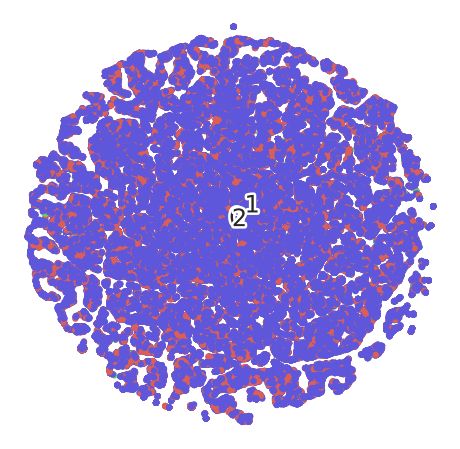

In [0]:
# labels = []
# tokens = []

# for word in model.wv.vocab:
#   if word in top1000list:
#       tokens.append(model[word])
#       labels.append(word)

# tokens = [model[w] for w in top1000list if w in labels]
# tokens = np.array(tokens)



# X=[]
# for sentence in to_consider:
#     X.append(sent_vectorizer(sentence, model1)) 

########.  https://www.datacamp.com/community/tutorials/introduction-t-sne

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 123







time_start = time.time()

# pca_50 = PCA(n_components=50)
# print(to_consider.shape)
# pca_result_50 = pca_50.fit_transform(X)

pca_50 = LinearDiscriminantAnalysis(n_components=50)
pca_result_50 = pca_50.fit(X, Y).transform(X)
print (time.time()-time_start)

print (np.sum(pca_50.explained_variance_ratio_))



time_start = time.time()


fashion_pca_tsne = TSNE(random_state=RS).fit_transform(pca_result_50)

print (time.time()-time_start)

# labelss = np.array(labelss)
# choose a color palette with seaborn.
num_classes = len(np.unique(Y))
palette = np.array(sns.color_palette("hls", num_classes))

# create a scatter plot.
f = plt.figure(figsize=(8, 8))
ax = plt.subplot(aspect='equal')
sc = ax.scatter(fashion_pca_tsne[:,0], fashion_pca_tsne[:,1], lw=0, s=40, c=palette[Y.astype(np.int)])
plt.xlim(-25, 25)
plt.ylim(-25, 25)
ax.axis('off')
ax.axis('tight')

# add the labels for each digit corresponding to the label
txts = []
for i in range(num_classes):

    # Position of each label at median of data points.

    xtext, ytext = np.median(fashion_pca_tsne[Y == i, :], axis=0)
    txt = ax.text(xtext, ytext, str(i), fontsize=24)
    txt.set_path_effects([
        PathEffects.Stroke(linewidth=5, foreground="w"),
        PathEffects.Normal()])
    txts.append(txt)


In [0]:
def drawing(model):
    labels = []
    tokens = []

    for word in model.wv.vocab:
      if word in top1000list:
          tokens.append(model[word])
          labels.append(word)
    
    tokens = [w for w in top1000list if w in tokens_prev]
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    
    plt.show()

    X = new_values
    km = KMeans(
        n_clusters=3, init='random',
        n_init=10, max_iter=300, 
        tol=1e-04, random_state=0
    )
    y_km = km.fit_predict(X)
    print (km.score(X))

    # silhouette_score = metrics.silhouette_score(X, labels, metric='euclidean')


    plt.scatter(
        X[y_km == 0, 0], X[y_km == 0, 1],
        s=50, c='lightgreen',
        marker='s', edgecolor='black',
        label='cluster 1'
    )

    plt.scatter(
        X[y_km == 1, 0], X[y_km == 1, 1],
        s=50, c='orange',
        marker='o', edgecolor='black',
        label='cluster 2'
    )

    plt.scatter(
        X[y_km == 2, 0], X[y_km == 2, 1],
        s=50, c='lightblue',
        marker='v', edgecolor='black',
        label='cluster 3'
    )

    # plot the centroids
    plt.scatter(
        km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
        s=250, marker='*',
        c='red', edgecolor='black',
        label='centroids'
    )
    plt.legend(scatterpoints=1)
    plt.grid()
    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


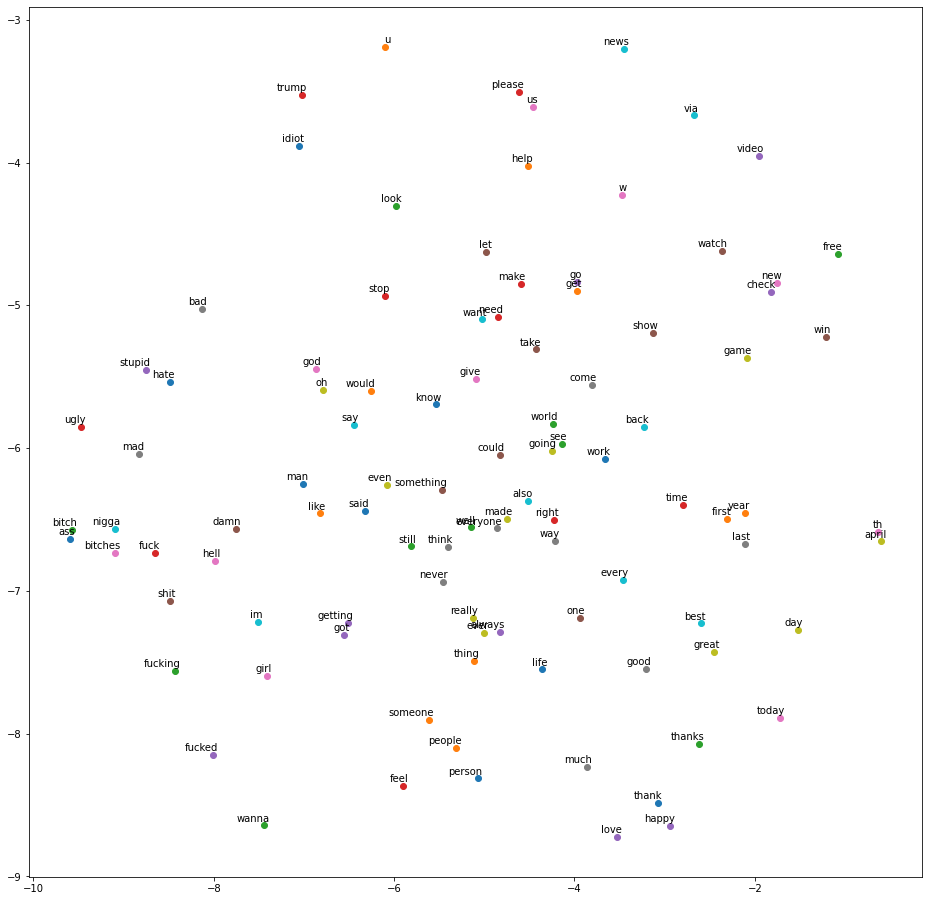

-243.4951


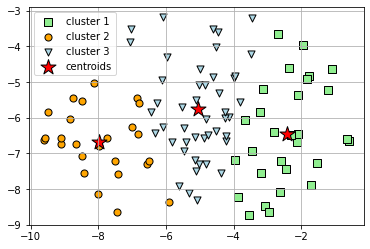

In [0]:
drawing(model)